In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from bisect import bisect_left, bisect_right
import seaborn as sns

### 1. Загрузка данных за май 2016 года.

In [3]:
filenames = ['/Users/ivan/Documents/Coursera_MIPT_YA_ML/C6_W1/yellow_tripdata_2016-05.csv',
             '/Users/ivan/Documents/Coursera_MIPT_YA_ML/C6_W1/yellow_tripdata_2016-04.csv',
             '/Users/ivan/Documents/Coursera_MIPT_YA_ML/C6_W1/yellow_tripdata_2016-03.csv']

In [4]:
%%time
df = pd.read_csv(filenames[0], parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], )

CPU times: user 1min 10s, sys: 11.9 s, total: 1min 22s
Wall time: 1min 30s


In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [6]:
df.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07,1.183685e+07
mean,1.529075e+00,1.662265e+00,6.110069e+00,-7.304978e+01,4.024234e+01,1.045014e+00,-7.311869e+01,4.028127e+01,1.349840e+00,1.334066e+01,3.291893e-01,4.972577e-01,1.831982e+00,3.422044e-01,2.996838e-01,1.664095e+01
std,4.991539e-01,1.304418e+00,5.155162e+03,8.212003e+00,4.523904e+00,6.203209e-01,7.902544e+00,4.353644e+00,4.942504e-01,1.188799e+01,4.585669e-01,4.473578e-02,2.665043e+00,1.760303e+00,1.300760e-02,1.450379e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-1.650819e+02,-4.456935e+01,1.000000e+00,-1.295732e+02,0.000000e+00,1.000000e+00,-4.100000e+02,-3.900000e+01,-2.700000e+00,-8.000000e+01,-1.500000e+01,-3.000000e-01,-4.103000e+02
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399179e+01,4.073611e+01,1.000000e+00,-7.399116e+01,4.073457e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.760000e+00
50%,2.000000e+00,1.000000e+00,1.720000e+00,-7.398136e+01,4.075375e+01,1.000000e+00,-7.397922e+01,4.075439e+01,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.260000e+00,0.000000e+00,3.000000e-01,1.230000e+01
75%,2.000000e+00,2.000000e+00,3.270000e+00,-7.396588e+01,4.076862e+01,1.000000e+00,-7.396164e+01,4.077012e+01,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.836000e+01
max,2.000000e+00,9.000000e+00,1.200000e+07,1.184089e+02,5.366724e+01,9.900000e+01,0.000000e+00,7.012994e+01,5.000000e+00,8.007000e+03,7.900000e+01,4.030000e+01,7.500000e+02,1.120680e+03,3.100000e+00,8.007800e+03


### 2. Проведем фильтрацию: удалим поездки с

нулевой длительностью;
<br>
нулевым количеством пассажиров;
<br>
нулевым расстоянием поездки по счётчику;
<br>
координатами начала, не попадающими в прямоугольник Нью-Йорка;
<br>


In [1]:
NY_grid   = [[-74.25559, -73.70001],[40.49612, 40.91553]] #Координаты Нью-Йорка

In [8]:
mask_to_clean = [(df.loc[:,'tpep_pickup_datetime'].values != df.loc[:,'tpep_dropoff_datetime'].values) &\
                     (df.loc[:,'passenger_count'].values != 0) &\
                     (df.loc[:,'trip_distance'].values   != 0) &\
                     (df.loc[:,'pickup_longitude'].values  > NY_grid[0][0]) &\
                     (df.loc[:,'pickup_longitude'].values  < NY_grid[0][1]) &\
                     (df.loc[:,'pickup_latitude'].values   > NY_grid[1][0]) &\
                     (df.loc[:,'pickup_latitude'].values   < NY_grid[1][1])][0]
    #df_.drop(df_[mask_to_clean].index, axis = 'rows', inplace = True)
df = df.iloc[mask_to_clean, :]

Округлим время посадки/высадки до часов.

In [9]:
df.loc[:,'tpep_pickup_datetime'] = df.tpep_pickup_datetime.dt.floor('h')
df.loc[:,'tpep_dropoff_datetime'] = df.tpep_dropoff_datetime.dt.floor('h')

Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты. Разобьем этот прямоугольник на 2500 одинаковых прямоугольных областей — по 50 интервалов вдоль каждой оси.

In [10]:
regions = pd.read_csv('/Users/ivan/Documents/Coursera_MIPT_YA_ML/C6_W1/regions.csv', delimiter=';', index_col=0)
regions.head(3)

,west,east,south,north
region,,,,
1,-74.25559,-74.244478,40.496120,40.504508
2,-74.25559,-74.244478,40.504508,40.512896
3,-74.25559,-74.244478,40.512896,40.521285


In [11]:
from collections import OrderedDict
NY_grid_n = 51  ## 50 интервалов это 51 точка
#Это пригодится для 2D heatmap'ов
NY_grid_xx, NY_grid_yy = np.meshgrid(np.linspace(NY_grid[0][0],NY_grid[0][1], NY_grid_n),
                                     np.linspace(NY_grid[1][0],NY_grid[1][1], NY_grid_n))
#А это для binned_statistic
NY_bins_xx = np.linspace(NY_grid[0][0],NY_grid[0][1], NY_grid_n)
NY_bins_yy = np.linspace(NY_grid[1][0],NY_grid[1][1], NY_grid_n)

#А это нижние левые точки квадратов регионов. Они понадобятся при присваивании региона начала поездки
NY_bnds_xx = np.array(list(OrderedDict.fromkeys(regions.west.values)))
NY_bnds_yy = np.array(list(OrderedDict.fromkeys(regions.south.values)))

Посчитаем количество поездок за каждый час из каждой области. 

In [12]:
%%time
bs = binned_statistic_2d(df.pickup_longitude.values, df.pickup_latitude.values,
                         None, bins = [NY_bins_xx,NY_bins_yy], statistic='count', expand_binnumbers = True)
df['region'] = (bs.binnumber[0] - 1) * 50 + bs.binnumber[1]

CPU times: user 2.48 s, sys: 980 ms, total: 3.46 s
Wall time: 3.73 s


На всякий случай сделаем функцию, которая возвращает номер региона в соответствии с его широтой и долготой.

In [13]:
def GetRegion(longitude, latitude, lon_bins = NY_bnds_xx, lat_bins = NY_bnds_yy):
    step = 50 #Так как 50 промежутков. То есть на каждую координату west в regions приходится 50 south
    bisect_01 = bisect_left(lon_bins, longitude) - 1
    bisect_02 = bisect_left(lat_bins, latitude)
    return bisect_01 * step + bisect_02

In [14]:
#Сделаем словаь, который будет кодировать время заказа одним целым числом от 0 до 743 (всего 24[часа] * 31[день])
#Словарь, как хэш-таблица, обработает значения за приемлемое время.
dt_rank_dict = {}
i = 0
for _, v in enumerate(np.unique(df.iloc[:, 1])):
    dt_rank_dict[v] = i
    i = i + 1
del(i)

In [15]:
%%time
df['dt_rank'] = df.loc[:, 'tpep_pickup_datetime'].apply(lambda x: dt_rank_dict[x.to_datetime64()])

CPU times: user 1min 28s, sys: 7.71 s, total: 1min 36s
Wall time: 1min 39s


### 3. Агрегируем данные за май 2016 года по часам и областям 

In [16]:
#Теперь создадим матрицу 2500х744, содержащую время, регион и количество заказов.
npickups = binned_statistic_2d(df.region.values, df.dt_rank.values,
                               values = None, statistic='count', 
                               bins = [range(0,2502,1),range(0,746,1)]).statistic
npickups = pd.DataFrame(npickups)
npickups.drop(labels=0, axis = 'rows', inplace = True)
npickups.drop(labels=744,  axis = 'columns', inplace = True)
npickups.shape

(2500, 744)

Создали sparse-матрицу, где по строки это id региона, а столбцы - час, начиная с начала месяца (май 2016г.) То есть стобец "0" соответствует периоду с 2016-05-01 00:00:00 до(! а не "по") 2016-05-01 01:00:00, а столбцы 23 и 24 соответствуют 23:00 1го числа и 00:00 2го числа месяца. Проверим это:

In [17]:
[dict(zip(dt_rank_dict.values(), dt_rank_dict.keys()))[key] for key in [0, 23, 24]]

[numpy.datetime64('2016-05-01T00:00:00.000000000'),
 numpy.datetime64('2016-05-01T23:00:00.000000000'),
 numpy.datetime64('2016-05-02T00:00:00.000000000')]

Теперь проверим, что поездки не потерялись:

In [18]:
print 'Кол-во колонок в очищенном датафрейме соответствует сумме значений в матрице npickups: ',
sum(sum(npickups.values)) == df.shape[0]

Кол-во колонок в очищенном датафрейме соответствует сумме значений в матрице npickups: 

True

### 4. Выведим первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [19]:
cols = [dict(zip(dt_rank_dict.values(), dt_rank_dict.keys()))[key] for key in range(len(npickups.columns))]

npickups.columns = cols
del(cols)
npickups.head()

,2016-05-01 00:00:00,2016-05-01 01:00:00,2016-05-01 02:00:00,2016-05-01 03:00:00,2016-05-01 04:00:00,2016-05-01 05:00:00,2016-05-01 06:00:00,2016-05-01 07:00:00,2016-05-01 08:00:00,2016-05-01 09:00:00,...,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Построим график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

Его координаты: 40°44′54.36″N, 73°59′08.36″W  (https://en.wikipedia.org/wiki/Empire_State_Building) или 
longitude = -73.985656, latitude = 40.748433

In [20]:
esb_coor = [-73.985656, 40.748433]
esb_regn = GetRegion(esb_coor[0], esb_coor[1])
print 'Здание Empire State Buiding находится в квадрате №: ', esb_regn

Здание Empire State Buiding находится в квадрате №:  1231


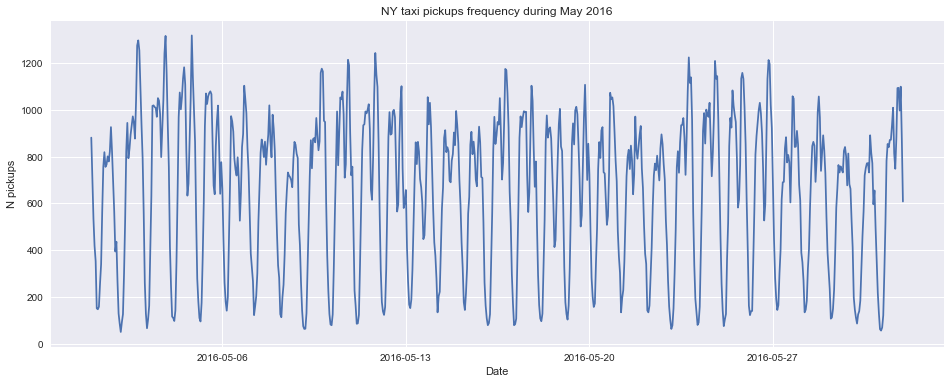

In [21]:
plt.figure(figsize = (16, 6))
x = npickups.columns
y = npickups.loc[1231,:]
plt.plot(x,y)
plt.xlabel('Date')
plt.ylabel('N pickups')
plt.title('NY taxi pickups frequency during May 2016')
plt.show()

### 6. Посчитаем, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [22]:
zero_pickups_pairs = np.sum(npickups.isin([0]).values)
print 'Всего в мае 2016 было {} пар час-ячейка, для которых не было \
совершено ни одной поездки.'.format(zero_pickups_pairs), 'это {}% от общего числа пар.'\
.format(round(100. * zero_pickups_pairs/(npickups.shape[0] * npickups.shape[1]), 1))

Всего в мае 2016 было 1718238 пар час-ячейка, для которых не было совершено ни одной поездки. это 92.4% от общего числа пар.


## Часть 2.

## 1. Загрузим агрегированные данные о поездках в мае 2016. 
Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.

In [23]:
npickups_total = npickups.sum(axis = 'columns').values
n_zero_pickups = sum(npickups_total == 0)

In [24]:
print 'Всего в мае 2016 из {} ячеек не было севершено ни одной поездки.'.format(n_zero_pickups)

Всего в мае 2016 из 1283 ячеек не было севершено ни одной поездки.


## 2. Нарисуем статическую карту Нью-Йорка.
Поставим на карте точку там, где находится Эмпайр-Стейт-Билдинг.

In [25]:
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

Воспользуемся дефолтным Basemap'ом.

In [26]:
west, south, east, north = NY_grid[0][0],NY_grid[1][0],NY_grid[0][1],NY_grid[1][1]
# Ниже - поездки суммарно.
npickups_total = npickups.sum(axis = 'columns').values
npickups_total = npickups_total.reshape(50,50).T

/Applications/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/Applications/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Applications/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


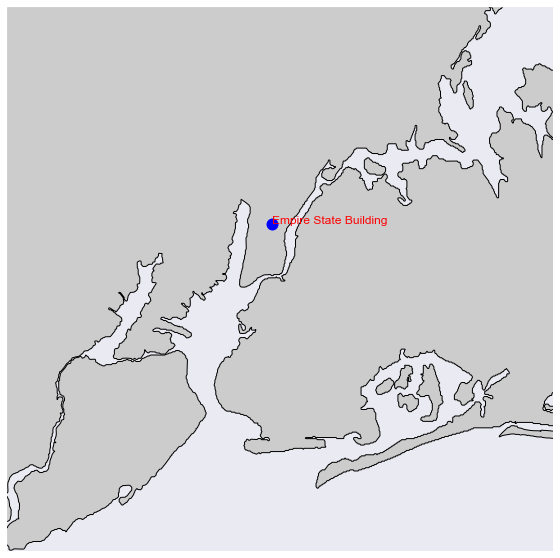

In [27]:
plt.figure(figsize = (10, 10)) 
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='f')
x, y = m(NY_bnds_xx, NY_bnds_yy)
x_esb, y_esb = m(esb_coor[0], esb_coor[1])
m.drawcoastlines()
m.fillcontinents()
m.plot(x_esb, y_esb, 'bo', markersize = 12)
plt.text(x_esb, y_esb, 'Empire State Building', color = 'red')
plt.show()

## 3. Поверх статической карты Нью-Йорка
визуализируем данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую окрашивается каждая ячейка, показывала суммарное количество поездок такси из неё.

Тут то же самое, добавляется колормеш.

/Applications/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Applications/anaconda/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


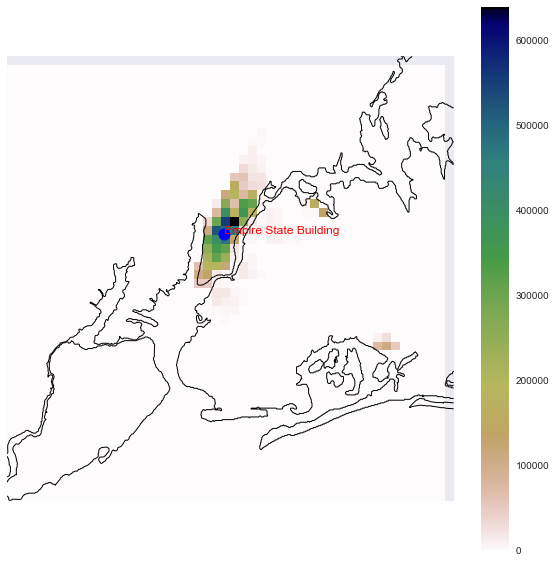

In [28]:
plt.figure(figsize = (10, 10)) 
m = Basemap(projection='merc', llcrnrlat=south, urcrnrlat=north,
            llcrnrlon=west, urcrnrlon=east, lat_ts=south, resolution='f')
m.drawcoastlines()
hue = m.pcolormesh(x,y,npickups_total, cmap = cm.gist_earth_r)
plt.colorbar(hue)
m.plot(x_esb, y_esb, 'bo', markersize = 12)
plt.text(x_esb, y_esb, 'Empire State Building', color = 'red')
plt.show()

## 4. Вставим интерактивную карту Нью-Йорка
— такую, которую можно прокручивать и увеличивать. Поставим метку там, где находится статуя свободы.

Для этого будем использовать Bokeh (поставляется с анакондой, но нужно дозагружать). 

In [29]:
## Переведем координаты в фомат Web Mercator.
def wgs84_to_web_mercator(longitude, latitude):
    """Converts decimal longitude/latitude to Web Mercator format"""
    k = 6378137
    x = longitude * (k * np.pi/180.0)
    y = np.log(np.tan((90 + latitude) * np.pi/360.0)) * k
    return x, y

In [30]:
NY_grid_mer = np.round([wgs84_to_web_mercator(x[0], x[1]) for x in [[east, north],[west, south]]])
NY_grid_mer #Web Mercator

array([[-8204248.,  4999890.],
       [-8266094.,  4938301.]])

Координаты Статуи Свободы: -74.0443, 40.6873

In [31]:
sol_coor = [-74.0443, 40.6873]
sol_coor_mer = np.round(wgs84_to_web_mercator(sol_coor[0], sol_coor[1]))
print 'Координаты Статуи Свободы в формате Web Mercator: ', sol_coor_mer

Координаты Статуи Свободы в формате Web Mercator:  [-8242574.  4966327.]


In [32]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON
from bokeh.models.annotations import Label

fig = figure(tools='pan, wheel_zoom',  x_range=(NY_grid_mer[1][0], NY_grid_mer[0][0]),
                                       y_range=(NY_grid_mer[1][1], NY_grid_mer[0][1]))
fig.circle(sol_coor_mer[0], sol_coor_mer[1], size = 10)

label = Label(x = sol_coor_mer[0], y = sol_coor_mer[1], x_offset=12, text="Statue of Liberty", text_baseline="middle")
fig.add_layout(label)

fig.axis.visible = False
fig.add_tile(CARTODBPOSITRON)
output_notebook()
show(fig)

Loading BokehJS ...

## 5. Нарисуем на интерактивной карте Нью-Йорка ячейки
так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.

Усредняем поездки и создаем координаты для Patch'ей.

In [33]:
npickups_mean = 1* npickups.sum(axis = 'columns').values / len(npickups.columns)
#npickups_mean = npickups_mean.reshape(50,50)

test_x = map(lambda x: [wgs84_to_web_mercator(x[0], 0)[0],
                        wgs84_to_web_mercator(x[0], 0)[0],
                        wgs84_to_web_mercator(x[1], 0)[0],
                        wgs84_to_web_mercator(x[1], 0)[0]], regions.values)
test_y = map(lambda x: [wgs84_to_web_mercator(0, x[2])[1],
                        wgs84_to_web_mercator(0, x[3])[1],
                        wgs84_to_web_mercator(0, x[3])[1],
                        wgs84_to_web_mercator(0, x[2])[1]], regions.values)

In [34]:
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper
)
from bokeh.palettes import Viridis6 as palette
fig = figure(tools='pan, wheel_zoom, hover, reset',  x_range=(NY_grid_mer[1][0], NY_grid_mer[0][0]),
                                       y_range=(NY_grid_mer[1][1], NY_grid_mer[0][1]))
fig.circle(sol_coor_mer[0], sol_coor_mer[1], size = 10)

label = Label(x = sol_coor_mer[0], y = sol_coor_mer[1], x_offset=12, text="Statue of Liberty", text_baseline="middle")
fig.add_layout(label)
color_mapper = LogColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    x=test_x,
    y=test_y,
    name=regions.index,
    rate=npickups_mean,
))

fig.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.4, line_color="white", line_width=0.5)
## Ховер это "следилка" мышкой. Наводим на карту, получаем значения полей в точке.
hover = fig.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Pickups mean", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]


fig.axis.visible = True
fig.add_tile(CARTODBPOSITRON)
output_notebook()
show(fig)

Loading BokehJS ...

## 6. 
Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруем ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитаем количество оставшихся. Проверим на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.


Воспользуемся готовыми координатами для патчей, только применим маску.

In [35]:
mask = np.argwhere(npickups_mean>5)
mask = [x[0] for x in mask]

In [36]:
print 'Количество ячеек с поездками > 5: ', len(mask)

Количество ячеек с поездками > 5:  102


In [37]:
test_x_clear = [test_x[i] for i in mask]
test_y_clear = [test_y[i] for i in mask]
npickups_mean_clear = [npickups_mean[i] for i in mask]

In [38]:
fig = figure(tools='pan, wheel_zoom, hover, reset',  x_range=(NY_grid_mer[1][0], NY_grid_mer[0][0]),
                                       y_range=(NY_grid_mer[1][1], NY_grid_mer[0][1]))
fig.circle(sol_coor_mer[0], sol_coor_mer[1], size = 10)

label = Label(x = sol_coor_mer[0], y = sol_coor_mer[1], x_offset=12, text="Statue of Liberty", text_baseline="middle")
fig.add_layout(label)

source = ColumnDataSource(data=dict(
    x=test_x_clear,
    y=test_y_clear,
    name=regions.index,
    rate=npickups_mean_clear,
))

fig.patches('x', 'y', source=source,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.4, line_color="white", line_width=0.5)

hover = fig.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Pickups mean", "@rate"),
    ("(Long, Lat)", "($x, $y)"),
]


fig.axis.visible = True
fig.add_tile(CARTODBPOSITRON)
output_notebook()
show(fig)

/Applications/anaconda/lib/python2.7/site-packages/bokeh/models/sources.py:89: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))


Loading BokehJS ...

Если увеличить и поползать по карте, то все ячейки на месте. Нет тех, что полность на воде, например.